### 1. Edge Detection

(a) Implement convolution process of smoothing Image 1 with a 5 x 5 Gaussian Filter with $\sigma$ = 1 and 2 , plot the corresponding output images.

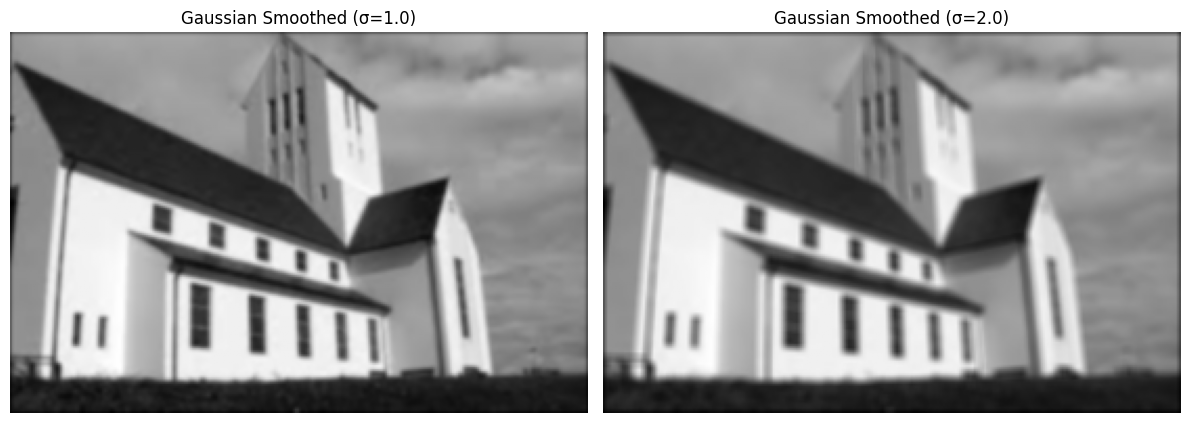

In [10]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

def convolution(input_image, filter_kernel):
    image_height, image_width = input_image.shape
    kernel_size = filter_kernel.shape[0]
    pad_size = kernel_size // 2
    padded_image = np.pad(input_image, pad_width=pad_size, mode='constant', constant_values=0)
    convolved_image = np.zeros_like(input_image, dtype=np.float64)
    for row in range(image_height):
        for col in range(image_width):
            region = padded_image[row:row + kernel_size, col:col + kernel_size]
            convolved_image[row, col] = np.sum(region * filter_kernel)
    return convolved_image

def gaussian_kernel_2d(k_size, sigma_val):
    kernel_matrix = np.zeros((k_size, k_size), dtype=np.float64)
    midpoint = k_size // 2
    
    for row in range(k_size):
        for col in range(k_size):
            delta_x = row - midpoint
            delta_y = col - midpoint
            kernel_matrix[row, col] = np.exp(-(delta_x**2 + delta_y**2) / (2 * sigma_val ** 2))

    kernel_matrix /= kernel_matrix.sum()
    return kernel_matrix

image = Image.open("image1.png").convert("L")
image_array = np.array(image, dtype=np.float64)

sigma_values = [1.0, 2.0]
smoothed_images = []

for sigma in sigma_values:
    kernel = gaussian_kernel_2d(5, sigma)
    smoothed_images.append(convolution(image_array, kernel))

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for idx, (sigma, smoothed_image) in enumerate(zip(sigma_values, smoothed_images)):
    axes[idx].imshow(smoothed_image, cmap='gray')
    axes[idx].set_title(f"Gaussian Smoothed (σ={sigma})")
    axes[idx].axis('off')

plt.tight_layout()
plt.show()


(b) Implement convolution process of convolving a 3 x 3 Sobel filters ($S_x$ and $S_y$) with the output images you obtained in step a. Plot the outputs of each step and the final edge map which combines edges in $x$ and $y$ directions

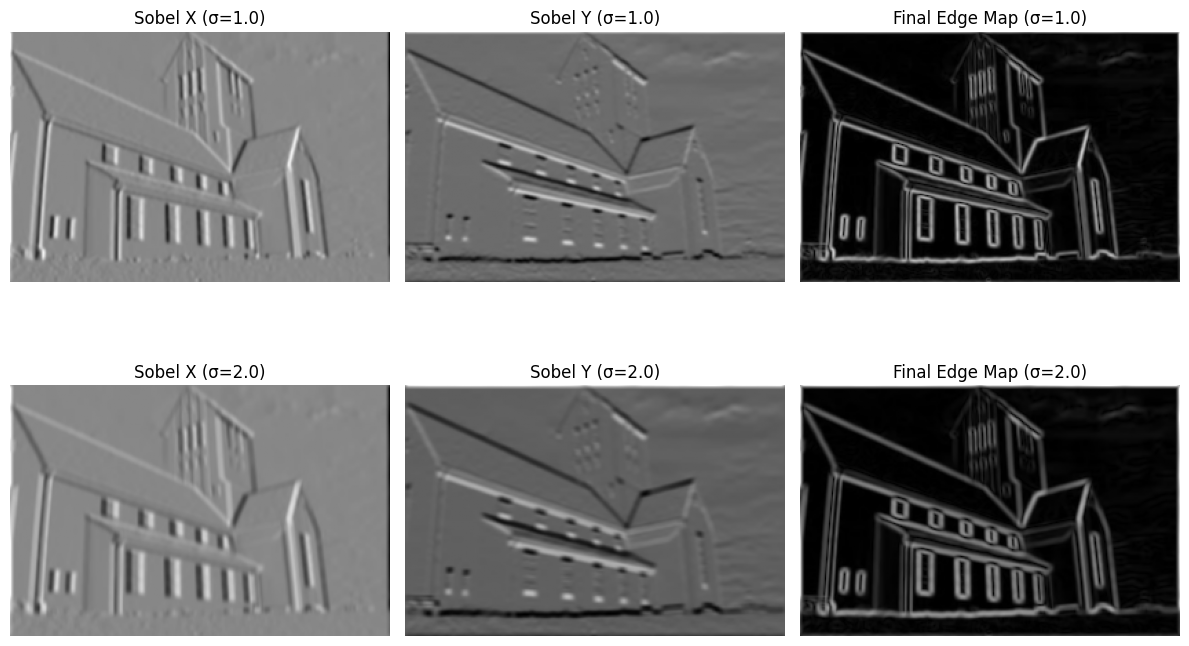

In [11]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

def sobel_kernels():
    Sx = np.array([[-1,0,1],
                   [-2,0,2],
                   [-1,0,1]], dtype=np.float64)
    
    Sy = np.array([[-1,-2,-1],
                   [0,0,0],
                   [1,2,1]], dtype=np.float64)
    
    return Sx, Sy

def edge_detection(image, Sx, Sy):
    grad_x = convolution(image, Sx)
    grad_y = convolution(image, Sy)
    edge_map = np.sqrt(grad_x**2 + grad_y**2)
    return grad_x, grad_y, edge_map

Sx, Sy = sobel_kernels()
edges = [edge_detection(smoothed, Sx, Sy) for smoothed in smoothed_images]

for idx, (sigma, (grad_x, grad_y, edge_map)) in enumerate(zip(sigma_values, edges)):
    axes[idx, 0].imshow(grad_x, cmap='gray')
    axes[idx, 0].set_title(f"Sobel X (σ={sigma})")
    axes[idx, 0].axis("off")

    axes[idx, 1].imshow(grad_y, cmap='gray')
    axes[idx, 1].set_title(f"Sobel Y (σ={sigma})")
    axes[idx, 1].axis("off")

    axes[idx, 2].imshow(edge_map, cmap='gray')
    axes[idx, 2].set_title(f"Final Edge Map (σ={sigma})")
    axes[idx, 2].axis("off")

plt.tight_layout()
plt.show()


(c) Implement convolution process of convolving Image 1 with $\frac{\partial G}{\partial x}$ and $\frac{\partial G}{\partial y}$ filters (5 × 5 filters and for $\sigma = 1$ and $2$) and plot the outputs of each step and the final edge map which combines edges in $x$ and $y$ directions.

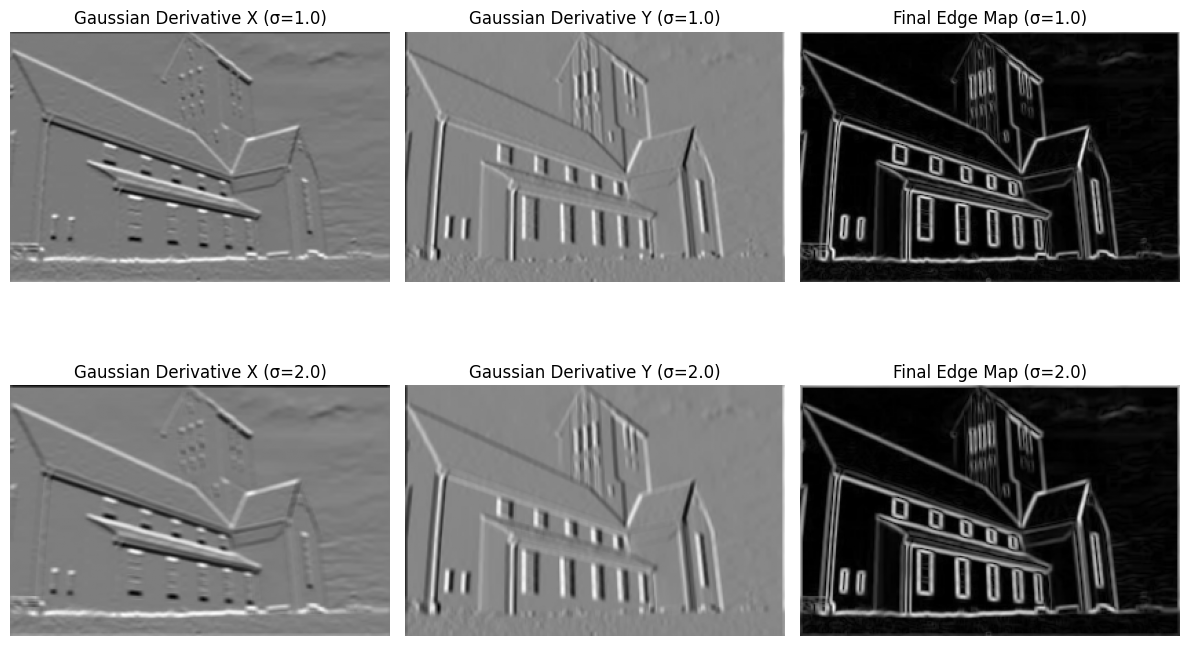

In [12]:
def gaussian_derivative(dim, sigma, direction='x'):
    center = dim // 2
    kernel = np.fromfunction(
        lambda i, j: (
            (-1 if direction == 'x' else 1) * (i - center) * np.exp(-((i - center) ** 2 + (j - center) ** 2) / (2.0 * sigma**2))
            if direction == 'x' else
            (-1) * (j - center) * np.exp(-((i - center) ** 2 + (j - center) ** 2) / (2.0 * sigma**2))
        ),
        (dim, dim),
        dtype=np.float64
    )
    return kernel * (1.0 / (2.0 * np.pi * sigma**4))

gaussian_kernels = [
    (gaussian_derivative(5, sigma, 'x'), gaussian_derivative(5, sigma, 'y'))
    for sigma in sigma_values
]

filtered_images = [
    (convolution(image_array, dx), convolution(image_array, dy))
    for dx, dy in gaussian_kernels
]

edge_maps = [np.hypot(Ix, Iy) for Ix, Iy in filtered_images]

fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for idx, (sigma, (Ix, Iy), edge_map) in enumerate(zip(sigma_values, filtered_images, edge_maps)):
    axes[idx, 0].imshow(Ix, cmap='gray')
    axes[idx, 0].set_title(f"Gaussian Derivative X (σ={sigma})")
    axes[idx, 0].axis("off")

    axes[idx, 1].imshow(Iy, cmap='gray')
    axes[idx, 1].set_title(f"Gaussian Derivative Y (σ={sigma})")
    axes[idx, 1].axis("off")

    axes[idx, 2].imshow(edge_map, cmap='gray')
    axes[idx, 2].set_title(f"Final Edge Map (σ={sigma})")
    axes[idx, 2].axis("off")

plt.tight_layout()
plt.show()


##### Observations of Final Output of b and c:
Edge Detection Sharpness: In part b, the edges appear more blurred and less defined, particularly along architectural features. In part c, the edges appear sharper and slightly more well-defined, especially when $\sigma = 1$, and get thicker but slightly more blurred when $\sigma = 2$.

Noise Sensitivity: The Sobel filter in part b is more sensitive to high-frequency noise and small intensity changes, leading to noisier and muddled edges. The Gaussian derivative filter in part c reduces noise better resulting in finer edges.

Edge Continuity: Sobel filtering in b results in some broken edges where intensity changes are weaker, especially when focusing on the right face of the tower. Gaussian derivative filtering in c produces more continuous and natural edges, as the Gaussian smoothing helps to integrate weaker edges into the response, resulting in high definition with the edges, again looking at the tower's right face as an example.

Effect of $\sigma$: Increasing $\sigma$ in part c makes edges smoother and broader, reducing noise but slightly blurring fine details. In contrast, Sobel filtering in part b does not involve smoothing, which keeps all fine details but retains noise.

Conclusion: 
The Gaussian derivative method part c provides better edge continuity and is less sensitive to noise, especially with $\sigma = 1$. The edges actually seems to get a bit worse when looking at $\sigma = 2$, but it isn't a huge difference.\
The Sobel method part b seems to be more sensitive to noise. It captures details like the windows and roofing but the edges are quite hazy.\
If noise reduction is important, Gaussian derivative filtering is better.

#### 2. Corner Detection
Implement Harris Corner Detection algorithm step by step as explained in the class. Apply your script to detect corners in image 1. Plot the corner response map, and the non-maximum suppression output.

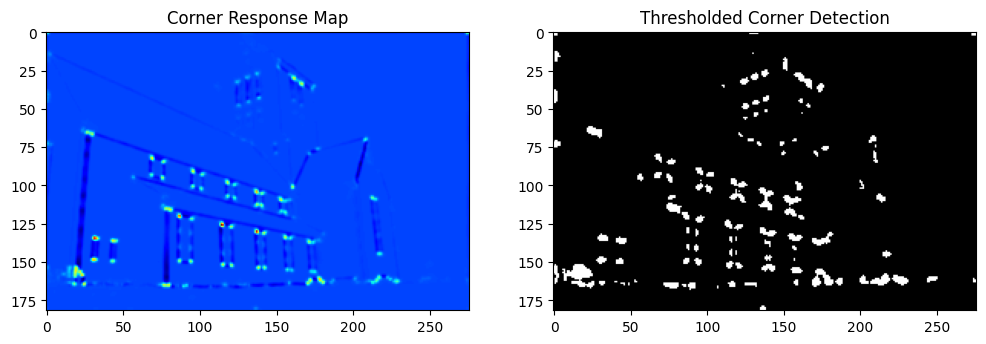

In [ ]:
def harris_corner_detection(image, k=0.04, threshold=0.01):
    Ix = convolution(image, Sx)
    Iy = convolution(image, Sy)

    Ixx = Ix**2
    Iyy = Iy**2
    Ixy = Ix * Iy

    gaussian_k = gaussian_kernel_2d(5, 1)
    Sxx = convolution(Ixx, gaussian_k)
    Syy = convolution(Iyy, gaussian_k)
    Sxy = convolution(Ixy, gaussian_k)

    detM = (Sxx * Syy) - (Sxy**2)
    traceM = Sxx + Syy
    R = detM - k * (traceM**2)

    corner_map = np.zeros_like(R)
    corner_map[R > threshold * R.max()] = 255

    return R, corner_map

response, corners = harris_corner_detection(image_array)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.title("Corner Response Map")
plt.imshow(response, cmap='jet')

plt.subplot(1, 2, 2)
plt.title("Thresholded Corner Detection")
plt.imshow(corners, cmap='gray')
plt.show()
